In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb


In [2]:
from rgf.sklearn import RGFClassifier

In [40]:
df_train = pd.read_csv("../data/train_dae.csv")
df_test = pd.read_csv("../data/test_dae.csv")
#df_train = pd.read_csv("../data/sparse/train_good.csv")
#df_test = pd.read_csv("../data/sparse/test_good.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 269)

In [41]:
test_ids.shape

(48744,)

In [36]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

positive_data = None
negative_data = None


In [37]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.5
num_boost_round = 10000
ncat = 43
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
          "categorical_feature" : range(ncat)
}

In [38]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params_xgb = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [39]:
NFOLDS = 2
ncat = 43
#X = features_train_t.values
XX_test = df_test.values

XX_train = df_train.values
labels_full = df_labels.values
# for xgb 

labels_train = df_labels.values
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))

x_score = []
x_score_xgb = []

best_trees = []
fold_scores = []
N = 8

oof_train_full = []
oof_test_full = [] 


for s in range(N):
    
    
    params['seed'] = s
    
    #x_train , x_val , y_train , y_val = train_test_split( df_train , df_labels , test_size = 0.2 , random_state=s)

    # split the entire data set in k-folds
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf = kfold.split( df_train , df_labels )
    
    oof_train = np.zeros((len(df_train),))
    
    
    oof_test = np.zeros((len(df_test),))
    oof_test_skf = np.empty((NFOLDS, len(df_test)))
    print( "Doing {}".format( s) )
    
    for i , (train_fold , validate ) in enumerate( kf ):
        
        X_train, X_validate, label_train, label_validate = XX_train[train_fold, :], XX_train[validate, :], labels_full[train_fold],labels_full[validate]

        positive_indx = label_train[ label_train == 1 ]
        positive_data = X_train[ label_train == 1  ]
        positive_data = pd.DataFrame( positive_data )

        negative_indx = label_train[ label_train == 0 ]
        negative_data = X_train[  label_train == 0  ]
    
        negative_data = pd.DataFrame( negative_data )
        negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s*5 )

        print(positive_data.shape)
        print(negative_data.shape )

        labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

        x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
        x_train_sampled["y"] = labels
        x_train_sampled = x_train_sampled.sample(frac = 1 ,random_state = s )
        labels_sampled = x_train_sampled["y"].values
    
        x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 ).values
    
        kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
        kf2 = kfold.split( x_train_sampled , labels_sampled  )
        best_trees = []
        fold_scores = []
        
        
        preds_validate_full = np.empty( ( NFOLDS , len( label_validate ) )   )
        
        
        for k  ,( train_fold2 , validate2 ) in enumerate( kf2):
            
            x_tr = x_train_sampled[ train_fold2 ]
            y_tr = labels_sampled[train_fold2]
            
            x_valid = x_train_sampled[ validate2 ]
            y_valid = labels_sampled[ validate2]
            
            dtrain = lgb.Dataset( x_tr , y_tr , categorical_feature = range(ncat)  )
            dvalid = lgb.Dataset(  x_valid  , y_valid , reference=dtrain , categorical_feature = range(ncat) )
            bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 300 , early_stopping_rounds = 100 ) 
            
            # predictiosn for the out of fold in whole set
            #preds_validate_full += bst.predict( X_validate )
            preds_validate_full[ k , : ] = bst.predict( X_validate )
            oof_test_skf[ k , : ] = bst.predict( XX_test )
            
        
        preds_validate_full = preds_validate_full.mean(axis = 0 )
        oof_train[ validate ] = preds_validate_full
        
        oof_test_parcial = oof_test_skf.mean( axis = 0 ) 
        oof_test += oof_test_parcial

    oof_test /= NFOLDS  
    
    
    oof_train = oof_train.reshape(-1, 1)
    oof_test = oof_test.reshape(-1, 1)
    
    oof_train_full.append( oof_train )
    oof_test_full.append( oof_test )
    print("Finnished")
    
    

Doing 0
(12436, 512)
(12410, 512)
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.684529	valid_0's auc: 0.574601
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.684468	valid_0's auc: 0.575065
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.682616	valid_0's auc: 0.586123
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.682874	valid_0's auc: 0.586343
(12389, 512)
(12415, 512)
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.682515	valid_0's auc: 0.582856
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.68228	valid_0's auc: 0.583549
Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

In [ ]:
new_train = np.hstack( oof_train_full )
new_test = np.hstack( oof_test_full )

In [29]:
print( "SUCCES")

SUCCES


In [30]:
new_test[0]

array([0.45918866, 0.44304732, 0.46658614, 0.42698438, 0.46948   ,
       0.49560702, 0.4791213 , 0.43318814])

In [31]:
new_train[0]

array([0.89180188, 0.88953235, 0.89234952, 0.89302691, 0.85035049,
       0.86294216, 0.89945512, 0.87929825])

In [32]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.5
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "goss",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.01,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 10,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "lambda_l1": 100 , 
          "min_gain_to_split" : 0.5 ,
         # "bagging_freq" : 1 , 
          "subsample" : 0.9
}

# Lightgbm model with oof_preds

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.346485	training's auc: 0.767513	valid_0's binary_logloss: 0.347487	valid_0's auc: 0.75787
[200]	training's binary_logloss: 0.267574	training's auc: 0.771847	valid_0's binary_logloss: 0.269367	valid_0's auc: 0.763569
[300]	training's binary_logloss: 0.248015	training's auc: 0.772956	valid_0's binary_logloss: 0.25041	valid_0's auc: 0.764537
[400]	training's binary_logloss: 0.243362	training's auc: 0.77329	valid_0's binary_logloss: 0.246123	valid_0's auc: 0.765009
[500]	training's binary_logloss: 0.242223	training's auc: 0.77348	valid_0's binary_logloss: 0.245141	valid_0's auc: 0.765129
[600]	training's binary_logloss: 0.241905	training's auc: 0.773625	valid_0's binary_logloss: 0.244862	valid_0's auc: 0.765266
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.242051	training's auc: 0.773568	valid_0's binary_logloss: 0.244992	valid_0's auc: 0.765295
fold 0  - 0.765294782404

KeyboardInterrupt: 

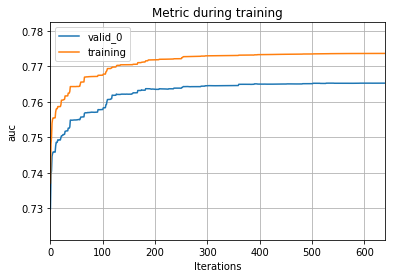

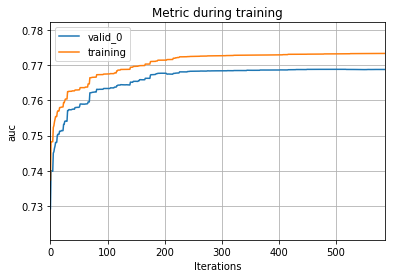

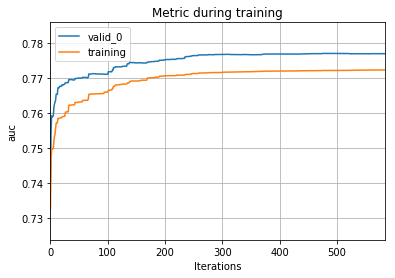

In [33]:
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( test_ids ))

NFOLDS = 10 

M = 16
x_score = []
fold_scores_lgb = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    fold_scores = []
    
    for i, (train_fold, validate) in enumerate(kf):
        evals_result = {}
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
        
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid , dtrain ] , verbose_eval = 100 , evals_result=evals_result, early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        score = roc_auc_score( label_validate , cv_train[validate])
        print("fold {}  - {} ".format( i ,  score ) )
        fold_scores_lgb.append( score )
        
        # save graphic
        ax = lgb.plot_metric(evals_result, metric='auc' )
        print("SAVING FIGURE") 
        plt.savefig( "../data/graphics/lgb/lc_s{}_f{}.png".format( s , i ) , format = "png" )
        #plt.show()
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))
    
    

0.817345685997514


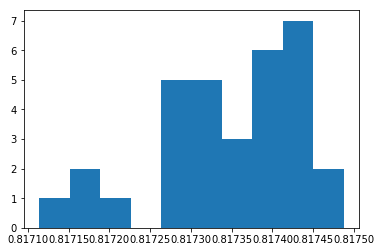

In [56]:
print( np.array(x_score).mean())
plt.hist( x_score )
plt.show()

In [100]:
final_pred_lgb = final_cv_pred/M

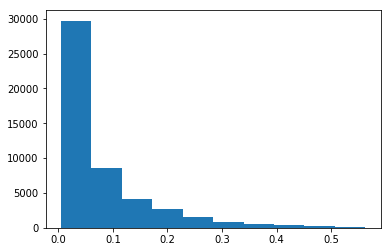

In [101]:
plt.hist( final_pred_lgb)
plt.show()

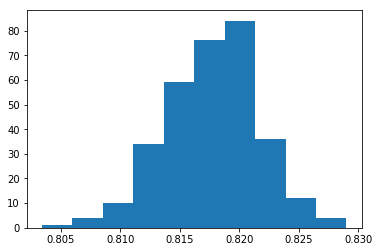

In [94]:
plt.hist( fold_scores_lgb ) 
plt.show()

# XGboost model with oof_preds

In [88]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 5000
params = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
          "gamma" : 20 , 
          "alpha" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [89]:
final_cv_train_xgbst = np.zeros(len(labels_train))
final_cv_pred_xgbst = np.zeros(len( test_ids ))

NFOLDS = 10

M = 32
x_score_xgbst = []
dtest = xgb.DMatrix( new_test )
fold_scores_xgb = []
for s in range( M ):
    
    params['seed'] = 2*s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2*s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]

        dtrain = xgb.DMatrix( X_train , label=label_train )
        dvalid = xgb.DMatrix( X_validate , label = label_validate )
        evallist = [ (dvalid, 'eval') ]
        bst = xgb.train(params, dtrain, num_boost_round, evals =  evallist , early_stopping_rounds=100 , verbose_eval=100 )
        #bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        #cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
        
        cv_pred += bst.predict( dtest, ntree_limit=bst.best_ntree_limit )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( dvalid , ntree_limit=bst.best_ntree_limit )
        score = roc_auc_score( label_validate , cv_train[validate] )
        fold_scores_xgb.append( score )
        print( "fold {} - {}".format(i , score ))
    
    cv_pred /= NFOLDS
    
    final_cv_train_xgbst += cv_train
    final_cv_pred_xgbst += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train_xgbst / (s + 1.)), s+1)
    
    x_score_xgbst.append(roc_auc_score( labels_train , cv_train))

[0]	eval-auc:0.773623
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802357
[200]	eval-auc:0.808022
[300]	eval-auc:0.81059
[400]	eval-auc:0.811442
[500]	eval-auc:0.81199
[600]	eval-auc:0.81222
[700]	eval-auc:0.812309
[800]	eval-auc:0.812322
[900]	eval-auc:0.812361
[1000]	eval-auc:0.812383
Stopping. Best iteration:
[958]	eval-auc:0.812383

fold 0 - 0.812382612035
[0]	eval-auc:0.772279
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.80515
[200]	eval-auc:0.809367
[300]	eval-auc:0.811598
[400]	eval-auc:0.812611
[500]	eval-auc:0.813309
[600]	eval-auc:0.813384
[700]	eval-auc:0.813381
[800]	eval-auc:0.813404
[900]	eval-auc:0.813407
[1000]	eval-auc:0.813423
Stopping. Best iteration:
[984]	eval-auc:0.813423

fold 1 - 0.813423365624
[0]	eval-auc:0.787589
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814536
[200]	eval-auc:0.818891
[300]	eval-auc:0.821009
[400]	eval-auc:0.821791
[500]	eval-auc:0.822303
[600]	eval-auc:

Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.81286
[200]	eval-auc:0.818208
[300]	eval-auc:0.820663
[400]	eval-auc:0.821669
[500]	eval-auc:0.822434
[600]	eval-auc:0.822779
[700]	eval-auc:0.822914
[800]	eval-auc:0.822924
[900]	eval-auc:0.822934
Stopping. Best iteration:
[829]	eval-auc:0.822934

fold 2 - 0.82293420296
[0]	eval-auc:0.768242
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806563
[200]	eval-auc:0.810642
[300]	eval-auc:0.813001
[400]	eval-auc:0.813768
[500]	eval-auc:0.814538
[600]	eval-auc:0.814844
[700]	eval-auc:0.814946
[800]	eval-auc:0.814947
Stopping. Best iteration:
[726]	eval-auc:0.814947

fold 3 - 0.814947458274
[0]	eval-auc:0.77332
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807521
[200]	eval-auc:0.813185
[300]	eval-auc:0.814934
[400]	eval-auc:0.815729
[500]	eval-auc:0.816522
[600]	eval-auc:0.816712
[700]	eval-auc:0.816773
Stopping. Best iteration:
[688]	eval-auc:0.816773

fold 4 - 0.

[200]	eval-auc:0.813399
[300]	eval-auc:0.815625
[400]	eval-auc:0.816587
[500]	eval-auc:0.81746
[600]	eval-auc:0.817739
[700]	eval-auc:0.817818
[800]	eval-auc:0.81787
Stopping. Best iteration:
[763]	eval-auc:0.81787

fold 4 - 0.817870244537
[0]	eval-auc:0.773783
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804501
[200]	eval-auc:0.810222
[300]	eval-auc:0.81164
[400]	eval-auc:0.812656
[500]	eval-auc:0.813284
[600]	eval-auc:0.813726
[700]	eval-auc:0.813773
Stopping. Best iteration:
[675]	eval-auc:0.813773

fold 5 - 0.813772658489
[0]	eval-auc:0.777402
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806866
[200]	eval-auc:0.810417
[300]	eval-auc:0.81222
[400]	eval-auc:0.813191
[500]	eval-auc:0.813732
[600]	eval-auc:0.814022
[700]	eval-auc:0.814061
[800]	eval-auc:0.814075
[900]	eval-auc:0.814081
Stopping. Best iteration:
[873]	eval-auc:0.814081

fold 6 - 0.814080795909
[0]	eval-auc:0.777673
Will train until eval-auc hasn't improved in 100

Stopping. Best iteration:
[1212]	eval-auc:0.816664

fold 6 - 0.816663734371
[0]	eval-auc:0.773583
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804039
[200]	eval-auc:0.809117
[300]	eval-auc:0.811747
[400]	eval-auc:0.81327
[500]	eval-auc:0.814404
[600]	eval-auc:0.814687
[700]	eval-auc:0.814714
[800]	eval-auc:0.81474
[900]	eval-auc:0.814755
[1000]	eval-auc:0.814779
[1100]	eval-auc:0.814791
[1200]	eval-auc:0.814801
Stopping. Best iteration:
[1152]	eval-auc:0.814801

fold 7 - 0.814801180071
[0]	eval-auc:0.78372
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.811024
[200]	eval-auc:0.815238
[300]	eval-auc:0.817065
[400]	eval-auc:0.818458
[500]	eval-auc:0.819153
[600]	eval-auc:0.819464
[700]	eval-auc:0.819501
[800]	eval-auc:0.819515
[900]	eval-auc:0.819522
[1000]	eval-auc:0.819545
[1100]	eval-auc:0.819563
[1200]	eval-auc:0.819572
Stopping. Best iteration:
[1119]	eval-auc:0.819572

fold 8 - 0.819572458421
[0]	eval-auc:0.782134
Will train un

[1000]	eval-auc:0.819224
Stopping. Best iteration:
[977]	eval-auc:0.819224

fold 8 - 0.819223996473
[0]	eval-auc:0.773286
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804415
[200]	eval-auc:0.809162
[300]	eval-auc:0.810829
[400]	eval-auc:0.812246
[500]	eval-auc:0.812808
[600]	eval-auc:0.812961
[700]	eval-auc:0.813023
[800]	eval-auc:0.813026
Stopping. Best iteration:
[786]	eval-auc:0.813026

fold 9 - 0.813026224076
cv score - on train:
0.8168464202332283
('current score in fold:', 0.8170816695623174, 9)
[0]	eval-auc:0.777198
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804581
[200]	eval-auc:0.810192
[300]	eval-auc:0.812124
[400]	eval-auc:0.813816
[500]	eval-auc:0.814893
[600]	eval-auc:0.815216
[700]	eval-auc:0.815361
[800]	eval-auc:0.815372
[900]	eval-auc:0.815412
Stopping. Best iteration:
[896]	eval-auc:0.815412

fold 0 - 0.815411585723
[0]	eval-auc:0.777809
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:

[800]	eval-auc:0.811464
[900]	eval-auc:0.811478
Stopping. Best iteration:
[834]	eval-auc:0.811478

fold 0 - 0.81147832713
[0]	eval-auc:0.779821
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808848
[200]	eval-auc:0.814735
[300]	eval-auc:0.816706
[400]	eval-auc:0.817202
[500]	eval-auc:0.818069
[600]	eval-auc:0.818247
[700]	eval-auc:0.818407
[800]	eval-auc:0.818498
[900]	eval-auc:0.818519
Stopping. Best iteration:
[844]	eval-auc:0.818519

fold 1 - 0.818519393263
[0]	eval-auc:0.777119
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810024
[200]	eval-auc:0.815179
[300]	eval-auc:0.817368
[400]	eval-auc:0.818463
[500]	eval-auc:0.819202
[600]	eval-auc:0.819387
Stopping. Best iteration:
[596]	eval-auc:0.819398

fold 2 - 0.819397777753
[0]	eval-auc:0.783136
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.811381
[200]	eval-auc:0.814675
[300]	eval-auc:0.816088
[400]	eval-auc:0.817117
[500]	eval-auc:0.817697
[600]	eval-

Stopping. Best iteration:
[683]	eval-auc:0.817537

fold 3 - 0.817536530946
[0]	eval-auc:0.768033
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.798881
[200]	eval-auc:0.802121
[300]	eval-auc:0.803595
[400]	eval-auc:0.804941
[500]	eval-auc:0.805565
[600]	eval-auc:0.805861
[700]	eval-auc:0.805865
Stopping. Best iteration:
[619]	eval-auc:0.805878

fold 4 - 0.805877490726
[0]	eval-auc:0.772592
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804585
[200]	eval-auc:0.809653
[300]	eval-auc:0.81207
[400]	eval-auc:0.813663
[500]	eval-auc:0.814473
[600]	eval-auc:0.81481
[700]	eval-auc:0.814877
[800]	eval-auc:0.814879
Stopping. Best iteration:
[709]	eval-auc:0.814881

fold 5 - 0.814880945916
[0]	eval-auc:0.776436
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807085
[200]	eval-auc:0.812469
[300]	eval-auc:0.814456
[400]	eval-auc:0.815454
[500]	eval-auc:0.816412
[600]	eval-auc:0.816499
[700]	eval-auc:0.81654
[800]	eval-au

Stopping. Best iteration:
[920]	eval-auc:0.821952

fold 5 - 0.821951907068
[0]	eval-auc:0.780268
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810752
[200]	eval-auc:0.81544
[300]	eval-auc:0.817723
[400]	eval-auc:0.818756
[500]	eval-auc:0.81941
[600]	eval-auc:0.819661
[700]	eval-auc:0.819698
[800]	eval-auc:0.81972
[900]	eval-auc:0.819728
[1000]	eval-auc:0.819739
[1100]	eval-auc:0.819746
Stopping. Best iteration:
[1038]	eval-auc:0.819746

fold 6 - 0.819746236865
[0]	eval-auc:0.778242
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807684
[200]	eval-auc:0.812113
[300]	eval-auc:0.814076
[400]	eval-auc:0.815484
[500]	eval-auc:0.816368
[600]	eval-auc:0.816425
[700]	eval-auc:0.8164
Stopping. Best iteration:
[616]	eval-auc:0.816444

fold 7 - 0.816444474933
[0]	eval-auc:0.777151
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.803301
[200]	eval-auc:0.809402
[300]	eval-auc:0.811615
[400]	eval-auc:0.812967
[500]	eval-a

fold 8 - 0.819571211292
[0]	eval-auc:0.776167
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804525
[200]	eval-auc:0.807549
[300]	eval-auc:0.809909
[400]	eval-auc:0.810945
[500]	eval-auc:0.811845
[600]	eval-auc:0.812045
[700]	eval-auc:0.812109
Stopping. Best iteration:
[688]	eval-auc:0.81211

fold 9 - 0.812110454078
cv score - on train:
0.8169983221449134
('current score in fold:', 0.8170981462327874, 18)
[0]	eval-auc:0.780864
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812549
[200]	eval-auc:0.815465
[300]	eval-auc:0.817079
[400]	eval-auc:0.818327
[500]	eval-auc:0.81913
[600]	eval-auc:0.819388
[700]	eval-auc:0.819413
[800]	eval-auc:0.819426
[900]	eval-auc:0.819429
Stopping. Best iteration:
[861]	eval-auc:0.819429

fold 0 - 0.819429170252
[0]	eval-auc:0.775035
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805518
[200]	eval-auc:0.809488
[300]	eval-auc:0.812945
[400]	eval-auc:0.813838
[500]	eval-auc:0.814

[0]	eval-auc:0.772164
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.80337
[200]	eval-auc:0.806587
[300]	eval-auc:0.809412
[400]	eval-auc:0.811276
[500]	eval-auc:0.812142
[600]	eval-auc:0.812504
[700]	eval-auc:0.812572
Stopping. Best iteration:
[682]	eval-auc:0.812577

fold 0 - 0.81257687939
[0]	eval-auc:0.776395
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806978
[200]	eval-auc:0.813518
[300]	eval-auc:0.814894
[400]	eval-auc:0.815686
[500]	eval-auc:0.816127
[600]	eval-auc:0.816323
[700]	eval-auc:0.816376
Stopping. Best iteration:
[618]	eval-auc:0.816377

fold 1 - 0.816376917534
[0]	eval-auc:0.776045
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808862
[200]	eval-auc:0.813353
[300]	eval-auc:0.815592
[400]	eval-auc:0.816619
[500]	eval-auc:0.81711
[600]	eval-auc:0.817348
[700]	eval-auc:0.817376
[800]	eval-auc:0.81738
Stopping. Best iteration:
[715]	eval-auc:0.81738

fold 2 - 0.817380152564
[0]	eval-auc:0.

[1000]	eval-auc:0.815941
[1100]	eval-auc:0.815949
Stopping. Best iteration:
[1032]	eval-auc:0.815949

fold 2 - 0.815948677403
[0]	eval-auc:0.78346
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810966
[200]	eval-auc:0.816285
[300]	eval-auc:0.817492
[400]	eval-auc:0.818583
[500]	eval-auc:0.81944
[600]	eval-auc:0.819727
[700]	eval-auc:0.819722
Stopping. Best iteration:
[646]	eval-auc:0.81975

fold 3 - 0.819749563223
[0]	eval-auc:0.78222
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812312
[200]	eval-auc:0.816855
[300]	eval-auc:0.817811
[400]	eval-auc:0.819408
[500]	eval-auc:0.819954
[600]	eval-auc:0.820096
[700]	eval-auc:0.82019
Stopping. Best iteration:
[696]	eval-auc:0.82019

fold 4 - 0.820189977118
[0]	eval-auc:0.774829
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802334
[200]	eval-auc:0.807992
[300]	eval-auc:0.810488
[400]	eval-auc:0.811937
[500]	eval-auc:0.81257
[600]	eval-auc:0.812722
[700]	eval-auc

[400]	eval-auc:0.813327
[500]	eval-auc:0.814156
[600]	eval-auc:0.814286
[700]	eval-auc:0.814374
[800]	eval-auc:0.814395
[900]	eval-auc:0.814414
[1000]	eval-auc:0.814422
Stopping. Best iteration:
[942]	eval-auc:0.814422

fold 5 - 0.814422132894
[0]	eval-auc:0.785181
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814383
[200]	eval-auc:0.819416
[300]	eval-auc:0.821647
[400]	eval-auc:0.822456
[500]	eval-auc:0.82277
[600]	eval-auc:0.822783
Stopping. Best iteration:
[562]	eval-auc:0.82281

fold 6 - 0.822809939788
[0]	eval-auc:0.777
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805331
[200]	eval-auc:0.810449
[300]	eval-auc:0.812301
[400]	eval-auc:0.813376
[500]	eval-auc:0.814308
[600]	eval-auc:0.814527
[700]	eval-auc:0.814535
Stopping. Best iteration:
[615]	eval-auc:0.814543

fold 7 - 0.814542853444
[0]	eval-auc:0.770548
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804622
[200]	eval-auc:0.808319
[300]	eval-auc

Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802379
[200]	eval-auc:0.807441
[300]	eval-auc:0.809906
[400]	eval-auc:0.810958
[500]	eval-auc:0.811611
[600]	eval-auc:0.811834
[700]	eval-auc:0.811846
Stopping. Best iteration:
[617]	eval-auc:0.811865

fold 8 - 0.811864826781
[0]	eval-auc:0.775859
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805546
[200]	eval-auc:0.811161
[300]	eval-auc:0.812719
[400]	eval-auc:0.813988
[500]	eval-auc:0.814854
[600]	eval-auc:0.815079
[700]	eval-auc:0.815125
[800]	eval-auc:0.815131
[900]	eval-auc:0.815134
[1000]	eval-auc:0.815148
[1100]	eval-auc:0.815149
Stopping. Best iteration:
[1046]	eval-auc:0.815149

fold 9 - 0.815149506616
cv score - on train:
0.8170146727765777
('current score in fold:', 0.8171013144450967, 27)
[0]	eval-auc:0.786791
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.81687
[200]	eval-auc:0.821459
[300]	eval-auc:0.823053
[400]	eval-auc:0.824418
[500]	eval-auc

[400]	eval-auc:0.814773
[500]	eval-auc:0.815414
[600]	eval-auc:0.81552
[700]	eval-auc:0.815536
Stopping. Best iteration:
[675]	eval-auc:0.815536

fold 0 - 0.815535631327
[0]	eval-auc:0.764245
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.7972
[200]	eval-auc:0.80103
[300]	eval-auc:0.804431
[400]	eval-auc:0.805605
[500]	eval-auc:0.806535
[600]	eval-auc:0.806845
[700]	eval-auc:0.806888
Stopping. Best iteration:
[633]	eval-auc:0.806908

fold 1 - 0.806907815766
[0]	eval-auc:0.784907
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814829
[200]	eval-auc:0.817836
[300]	eval-auc:0.81959
[400]	eval-auc:0.82048
[500]	eval-auc:0.821159
[600]	eval-auc:0.82131
[700]	eval-auc:0.821356
[800]	eval-auc:0.821364
Stopping. Best iteration:
[799]	eval-auc:0.821364

fold 2 - 0.821364442666
[0]	eval-auc:0.77925
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808873
[200]	eval-auc:0.813207
[300]	eval-auc:0.815909
[400]	eval-auc:0.8

[300]	eval-auc:0.81612
[400]	eval-auc:0.817337
[500]	eval-auc:0.818003
[600]	eval-auc:0.818222
[700]	eval-auc:0.818297
Stopping. Best iteration:
[662]	eval-auc:0.818299

fold 3 - 0.818298812341
[0]	eval-auc:0.776446
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.803283
[200]	eval-auc:0.809169
[300]	eval-auc:0.811983
[400]	eval-auc:0.812998
[500]	eval-auc:0.814013
[600]	eval-auc:0.81442
[700]	eval-auc:0.81452
[800]	eval-auc:0.814551
[900]	eval-auc:0.814575
[1000]	eval-auc:0.814587
[1100]	eval-auc:0.8146
[1200]	eval-auc:0.814608
Stopping. Best iteration:
[1114]	eval-auc:0.814608

fold 4 - 0.814607597253
[0]	eval-auc:0.781795
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812163
[200]	eval-auc:0.815318
[300]	eval-auc:0.817653
[400]	eval-auc:0.819133
[500]	eval-auc:0.820139
[600]	eval-auc:0.820549
[700]	eval-auc:0.820658
Stopping. Best iteration:
[644]	eval-auc:0.820659

fold 5 - 0.820658751857
[0]	eval-auc:0.781372
Will train until eva

In [91]:
np.array( x_score_xgbst).mean()

0.8169864005722789

In [72]:
np.array( x_score_xgbst).

7.968120993222278e-05

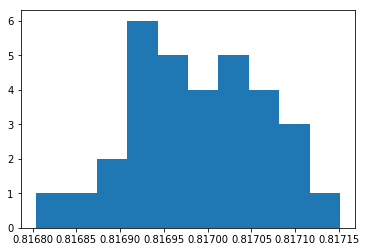

In [95]:
plt.hist( x_score_xgbst )
plt.show()


In [102]:
final_xgb = final_cv_pred_xgbst/M

In [103]:
final_xgb

array([0.03161012, 0.11100603, 0.01604727, ..., 0.01432699, 0.03582011,
       0.2561009 ])

In [104]:
final = final_cv_pred/M

In [105]:
final_train = final_cv_train_xgbst/M
final_train_lgb = final_cv_train/M

In [106]:
final_pos = final_train[ labels_train == 1  ]
final_neg = final_train[labels_train == 0 ]
final_pos_lgb = final_train_lgb[ labels_train == 1  ]
final_neg_lgb = final_train_lgb[labels_train == 0 ]

In [107]:
print( np.array( x_score).mean() )

0.8177096477679208


In [108]:
roc_auc_score( labels_train , final_cv_train/M ) 

0.8177907443613184

In [109]:
a = len(final_pos)

In [110]:
b = len(final_neg)

In [111]:
final_mean = ( final_xgb +  final_pred_lgb)/2.0

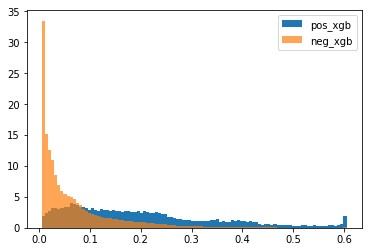

In [116]:
plt.hist( final_pos , density = True , bins = 100 , label = "pos_xgb" )
plt.hist(  final_neg  , density = True , bins = 100 , alpha = 0.7 , label = "neg_xgb")
#plt.hist( final_pos_lgb , density = True , bins = 100 , label = "pos_lgb" )
#plt.hist(  final_neg_lgb , density = True , bins = 100 , alpha = 0.7 , label = "neg_lgb")

plt.legend()
plt.show()

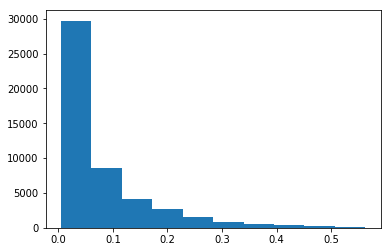

In [117]:
#plt.hist( final_xgb)
#plt.hist( final_mean )
plt.hist( final_pred_lgb )
plt.show()

In [111]:
final_logi.shape

(307511,)

In [43]:
x_score

[0.8169483052586347,
 0.8190930615893933,
 0.8182237024787657,
 0.8180733051241529,
 0.816361926066463,
 0.8186181301271797,
 0.8174379841161038,
 0.8168223110545245,
 0.816578728843284,
 0.8182051318826529,
 0.8168356163064975,
 0.8175523110027269,
 0.8172393537268681,
 0.8182943858105127,
 0.8162965355095738,
 0.8186261278558308]

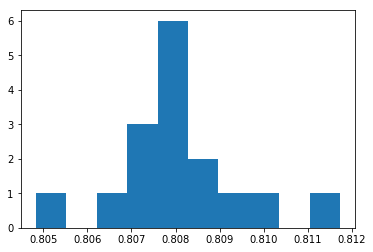

In [98]:
plt.hist( x_score_xgb )
plt.show()

In [48]:
np.array( x_score_xgb ).std()

0.001428089557675824

In [49]:
np.array( x_score ).std()

0.0008594220828512764

In [99]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_mean }).to_csv('../data/pred_mean_oof.csv', index=False)

Plot feature importances...


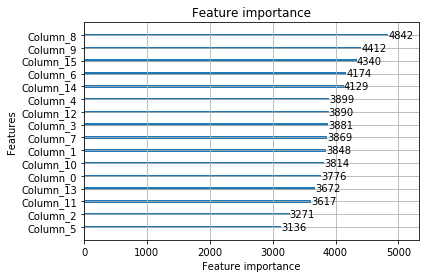

In [48]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=20)
plt.show()